### Import libraries

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from skimage.restoration import denoise_tv_chambolle
import cvxpy as cp

### Image Quality Metrics

In [2]:
def gaussian(sigma,size):
    gaussian_filter = np.zeros((size,size))

    for i in range(size):
        for j in range(size):
            gaussian_filter[i][j] = np.exp(-((i-size//2)**2+(j-size//2)**2)/(2*sigma**2))

    gaussian_filter/= np.sum(gaussian_filter)

    return gaussian_filter

def MSE_PSNR(I,J):
    M,N = I.shape
    MSE = np.sum((I.astype("float") - J.astype("float")) ** 2)
    MSE /= M*N
    L = 1
    PSNR = 10*np.log10(L**2/MSE)
    
    return MSE,PSNR
def SSIM(I,J):
    
    ## Guassian Window for weight
    w = gaussian(0.5,11)
    M,N = I.shape
    L =1 
    C1,C2,C3  = (0.01*L)**2,(0.03*L)**2,((0.03*L)**2)/2
    L,C,S =  np.zeros((M,N)),np.zeros((M,N)),np.zeros((M,N))
    for i in range(5,M-5):
        for j in range(5,N-5):
            
            ## Luminance
            meanI = np.sum(w*I[i-5:i+6,j-5:j+6])
            meanJ = np.sum(w*J[i-5:i+6,j-5:j+6])
            L[i][j] = (2*meanI*meanJ + C1)/(meanI**2 + meanJ**2 + C1)

            
            ## Contrast
            sigI = np.sqrt(np.sum(w*(I[i-5:i+6,j-5:j+6] - meanI)**2))
            sigJ = np.sqrt(np.sum(w*(J[i-5:i+6,j-5:j+6] - meanJ)**2))
            C[i][j] = (2*sigI*sigJ + C2 )/(sigI**2 + sigJ**2 + C2)
            
            ## Similairity
            sigIJ = np.sum(w*(I[i-5:i+6,j-5:j+6] - meanI)*(J[i-5:i+6,j-5:j+6] - meanJ))
            S[i][j] = (sigIJ + C3)/(sigI*sigJ + C3)
            
    SSIM = L*C*S
    num = np.count_nonzero(SSIM)
    MSSIM  = np.sum(SSIM)/num
    # SSIM_MAP = 255*SSIM

    return MSSIM,SSIM

In [57]:
def gradient(u):
    grad_x = np.gradient(u, axis=0)
    grad_y = np.gradient(u, axis=1)
    return grad_x, grad_y

def divergence(grad_x, grad_y):
    div_x = np.gradient(grad_x, axis=0)
    div_y = np.gradient(grad_y, axis=1)
    return div_x + div_y
def proj(px, py):
        norm = np.maximum(1, np.sqrt(px ** 2 + py ** 2))
        return px / norm, py / norm

### Chambolle's Algorithm

In [58]:
def chambolle_denoising(u0, lambda_, max_iter=100, tol=1e-6):
    

    u = u0.copy()
    px, py = np.zeros_like(u), np.zeros_like(u)
    theta = 0.125

    for k in range(max_iter):
        u_old = u.copy()

        grad_x, grad_y = gradient(u)
        px_new, py_new = proj(px + theta * grad_x, py + theta * grad_y)
        px, py = px_new, py_new

        div_p = divergence(px, py)
        u = (u0 + lambda_ * div_p) / (1 + lambda_)

        if np.linalg.norm(u - u_old) < tol:
            break

    return u


### Gradient Descent Method - (Rudin,Osher,Fatemi,1992)

In [6]:
def rof_denoising(u0, lambda_, max_iter=100, tol=1e-6):
    u = u0.copy()

    tau = 1 / 8

    for k in range(max_iter):
        grad_x, grad_y = gradient(u)
        grad_mag = np.sqrt(grad_x**2 + grad_y**2)
        div = divergence(grad_x / (grad_mag + 1e-12), grad_y / (grad_mag + 1e-12))
        u_new = u - tau * (div - lambda_ * (u - u0))

        if np.linalg.norm(u_new - u) < tol:
            break

    u = np.clip(u_new, 0, 1)

    return u

In [47]:
def cvx_denoising(u0, lambda_):
    u = cp.Variable(u0.shape)
    obj = cp.Minimize(cp.sum_squares(u - u0) + lambda_ * cp.tv(u))
    prob = cp.Problem(obj)
    prob.solve(solver=cp.SCS)

    return u.value

In [7]:
def add_noise(img, sigma):
    noise = np.random.normal(0, sigma, img.shape)
    noisy_img = img + noise
    noisy_img = noisy_img
    return np.clip(noisy_img, 0, 1)

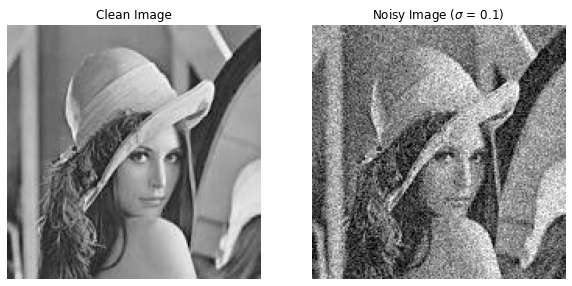

In [77]:
clean_image = plt.imread('lena.jpeg')
clean_image = clean_image[:, :, 0]/255
sigma = 0.1
plt.figure(figsize=(10, 5))
noisy_image = add_noise(clean_image, sigma)
plt.subplot(1, 2, 1)
plt.imshow(clean_image, cmap='gray')
plt.title('Clean Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(noisy_image, cmap='gray')
plt.title('Noisy Image ($ \sigma $ = {})'.format(sigma))
plt.axis('off')
plt.show()


#### cvx solution

In [62]:
lambda_val = 0.15
denoised_img_cvx = cvx_denoising(noisy_image, lambda_val)

##### Gradient Descent

In [63]:
lambda_ = 0.005 
max_iter = 30000
denoised_image_rof = rof_denoising(noisy_image, lambda_,max_iter)

In [64]:
# Denoise noisy image using Chambolle's method
lambda_ = 0.05
max_iter = 10000
denoised_image_chambelle = chambolle_denoising(noisy_image, lambda_, max_iter)

In [65]:
## Compute SSIM and PSNR for all the images
PSNR_cvx = MSE_PSNR(clean_image,denoised_img_cvx)[1]
SSIM_cvx = SSIM(clean_image,denoised_img_cvx)[0]

PSNR_rof = MSE_PSNR(clean_image,denoised_image_rof)[1]
SSIM_rof = SSIM(clean_image,denoised_image_rof)[0]

PSNR_chambelle = MSE_PSNR(clean_image,denoised_image_chambelle)[1]
SSIM_chambelle = SSIM(clean_image,denoised_image_chambelle)[0]

PSNR_noisy = MSE_PSNR(clean_image,noisy_image)[1]
SSIM_noisy = SSIM(clean_image,noisy_image)[0]

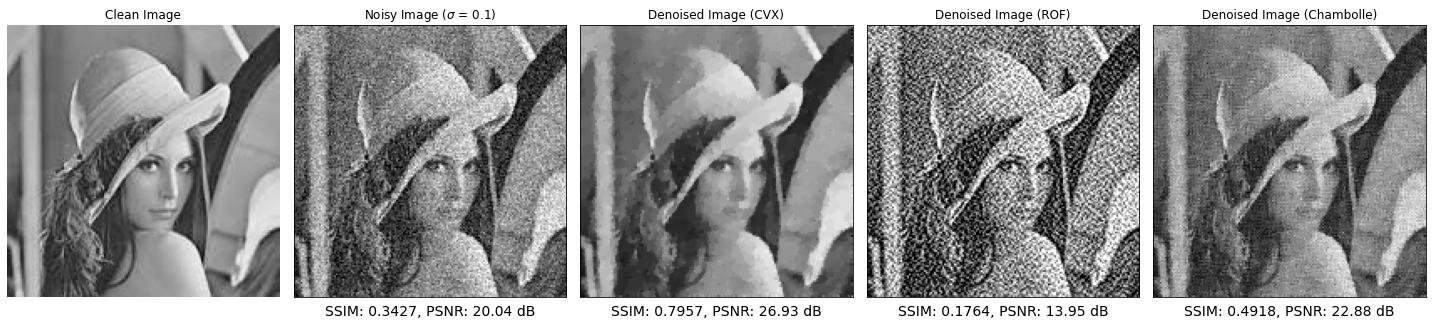

In [68]:

# SSIM and PSNR values for each image
ssim_values = [1, SSIM_noisy, SSIM_cvx, SSIM_rof, SSIM_chambelle]
psnr_values = [1, PSNR_noisy, PSNR_cvx, PSNR_rof, PSNR_chambelle]

# Number of images
images = [clean_image, noisy_image, denoised_img_cvx, denoised_image_rof, denoised_image_chambelle]
num_images = len(images)
# Set up the plotting grid
fig, axes = plt.subplots(1, 5, figsize=(num_images*4, 10))

# Loop over images and display them along with SSIM and PSNR values
for i, (img, ssim, psnr, ax) in enumerate(zip(images, ssim_values, psnr_values, axes)):
    ax.imshow(img, cmap='gray')
    if i == 0:
        ax.set_title("Clean Image")
        ax.axis('off')
    elif i == 1:
        ax.set_title(f"Noisy Image ($ \sigma $ = {sigma})")
    elif i == 2:
        ax.set_title(f"Denoised Image (CVX)")
    elif i == 3:
        ax.set_title(f"Denoised Image (ROF)")
    elif i == 4:
        ax.set_title(f"Denoised Image (Chambolle)")
    

    if i != 0:
        ax.set_xlabel(f"SSIM: {ssim:.4f}, PSNR: {psnr:.2f} dB", fontsize=14)
        ax.set_xticks([])
        ax.set_yticks([])   

plt.tight_layout()
plt.show()

In [78]:
### Varying lambda for CVX denoising
lambda_vals = np.linspace(0.01, 0.5, 10)
PSNR_cvx = []
SSIM_cvx = []
for lambda_ in lambda_vals:
    denoised_img_cvx = cvx_denoising(noisy_image, lambda_)
    PSNR_cvx.append(MSE_PSNR(clean_image,denoised_img_cvx)[1])
    SSIM_cvx.append(SSIM(clean_image,denoised_img_cvx)[0])
    

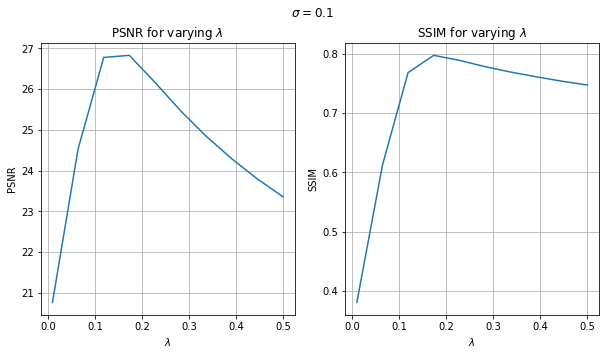

In [79]:
## PLot PSNR and SSIM values for varying lambda - 2 different plots
plt.figure(figsize=(10, 5))
plt.suptitle(' $\sigma = 0.1$')
plt.subplot(1, 2, 1)
plt.plot(lambda_vals, PSNR_cvx)
plt.xlabel('$ \lambda $')
plt.ylabel('PSNR')
plt.title('PSNR for varying $ \lambda $')
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(lambda_vals, SSIM_cvx)
plt.xlabel('$ \lambda $')
plt.ylabel('SSIM')
plt.title('SSIM for varying $ \lambda $')
plt.grid()
plt.show()




In [72]:
### PSNR and SSIM for varying sigma values for CVX denoising
sigma_vals = np.linspace(0.01, 0.5, 10)
PSNR_cvx = []
SSIM_cvx = []
for sigma in sigma_vals:
    noisy_image = add_noise(clean_image, sigma)
    lambda_val = sigma*1.5
    denoised_img_cvx = cvx_denoising(noisy_image, lambda_val)
    PSNR_cvx.append(MSE_PSNR(clean_image,denoised_img_cvx)[1])
    SSIM_cvx.append(SSIM(clean_image,denoised_img_cvx)[0])



In [73]:
## Tabular Format Results
print('PSNR and SSIM values for varying sigma values for CVX denoising')
print('Sigma \t PSNR \t SSIM')
for i in range(len(sigma_vals)):
    print('{:.2f} \t {:.2f} \t {:.2f}'.format(sigma_vals[i], PSNR_cvx[i], SSIM_cvx[i]))


PSNR and SSIM values for varying sigma values for CVX denoising
Sigma 	 PSNR 	 SSIM
0.01 	 39.77 	 0.97
0.06 	 29.05 	 0.84
0.12 	 26.20 	 0.77
0.17 	 24.54 	 0.73
0.23 	 23.37 	 0.70
0.28 	 22.14 	 0.68
0.34 	 21.28 	 0.68
0.39 	 20.42 	 0.67
0.45 	 19.64 	 0.66
0.50 	 18.65 	 0.65


In [80]:
## Calculate PSNR and SSIM for varying lamda values at different sigma values for CVX denoising
sigma_vals = np.linspace(0.01, 0.5, 5)
lambda_vals = np.linspace(0.01, 0.5, 5)
PSNR_cvx = []
SSIM_cvx = []
for sigma in sigma_vals:
    noisy_image = add_noise(clean_image, sigma)
    for lambda_ in lambda_vals:
        denoised_img_cvx = cvx_denoising(noisy_image, lambda_)
        PSNR_cvx.append(MSE_PSNR(clean_image,denoised_img_cvx)[1])
        SSIM_cvx.append(SSIM(clean_image,denoised_img_cvx)[0])

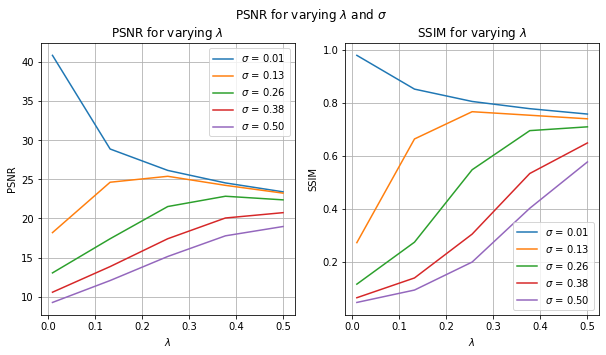

In [85]:
## PLot PSNR for varying lambda and sigma values in the same plot
## Do the same for SSIM

plt.figure(figsize=(10, 5))
plt.suptitle('PSNR for varying $ \lambda $ and $ \sigma $')
plt.subplot(1, 2, 1)
plt.plot(lambda_vals, PSNR_cvx[:5], label='$ \sigma $ = {:.2f}'.format(sigma_vals[0]))
plt.plot(lambda_vals, PSNR_cvx[5:10], label='$ \sigma $ = {:.2f}'.format(sigma_vals[1]))
plt.plot(lambda_vals, PSNR_cvx[10:15], label='$ \sigma $ = {:.2f}'.format(sigma_vals[2]))
plt.plot(lambda_vals, PSNR_cvx[15:20], label='$ \sigma $ = {:.2f}'.format(sigma_vals[3]))
plt.plot(lambda_vals, PSNR_cvx[20:25], label='$ \sigma $ = {:.2f}'.format(sigma_vals[4]))
plt.xlabel('$ \lambda $')
plt.ylabel('PSNR')
plt.title('PSNR for varying $ \lambda $')
plt.legend()
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(lambda_vals, SSIM_cvx[:5], label='$ \sigma $ = {:.2f}'.format(sigma_vals[0]))
plt.plot(lambda_vals, SSIM_cvx[5:10], label='$ \sigma $ = {:.2f}'.format(sigma_vals[1]))
plt.plot(lambda_vals, SSIM_cvx[10:15], label='$ \sigma $ = {:.2f}'.format(sigma_vals[2]))
plt.plot(lambda_vals, SSIM_cvx[15:20], label='$ \sigma $ = {:.2f}'.format(sigma_vals[3]))
plt.plot(lambda_vals, SSIM_cvx[20:25], label='$ \sigma $ = {:.2f}'.format(sigma_vals[4]))
plt.xlabel('$ \lambda $')
plt.ylabel('SSIM')
plt.title('SSIM for varying $ \lambda $')
plt.legend()
plt.grid()
plt.show()



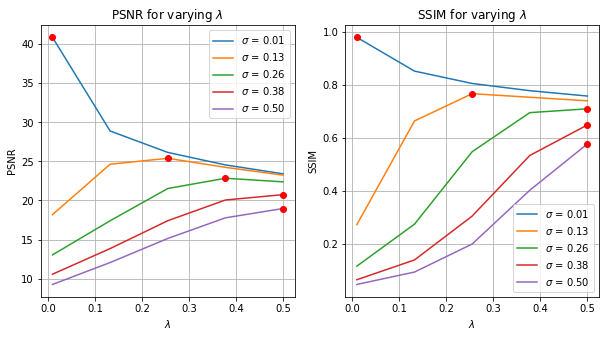

In [88]:
## PLot PSNR for varying lambda and sigma values in the same plot
## Do the same for SSIM
## Plot the locii of lambda and sigma values for which PSNR and SSIM are maximum

plt.figure(figsize=(10, 5))
# plt.suptitle('PSNR for varying $ \lambda $ and $ \sigma $')
plt.subplot(1, 2, 1)
plt.plot(lambda_vals, PSNR_cvx[:5], label='$ \sigma $ = {:.2f}'.format(sigma_vals[0]))
plt.plot(lambda_vals, PSNR_cvx[5:10], label='$ \sigma $ = {:.2f}'.format(sigma_vals[1]))
plt.plot(lambda_vals, PSNR_cvx[10:15], label='$ \sigma $ = {:.2f}'.format(sigma_vals[2]))
plt.plot(lambda_vals, PSNR_cvx[15:20], label='$ \sigma $ = {:.2f}'.format(sigma_vals[3]))
plt.plot(lambda_vals, PSNR_cvx[20:25], label='$ \sigma $ = {:.2f}'.format(sigma_vals[4]))
plt.plot(lambda_vals[np.argmax(PSNR_cvx[:5])], np.max(PSNR_cvx[:5]), 'ro')
plt.plot(lambda_vals[np.argmax(PSNR_cvx[5:10])], np.max(PSNR_cvx[5:10]), 'ro')
plt.plot(lambda_vals[np.argmax(PSNR_cvx[10:15])], np.max(PSNR_cvx[10:15]), 'ro')
plt.plot(lambda_vals[np.argmax(PSNR_cvx[15:20])], np.max(PSNR_cvx[15:20]), 'ro')
plt.plot(lambda_vals[np.argmax(PSNR_cvx[20:25])], np.max(PSNR_cvx[20:25]), 'ro')
plt.xlabel('$ \lambda $')
plt.ylabel('PSNR')
plt.title('PSNR for varying $ \lambda $')
plt.legend()
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(lambda_vals, SSIM_cvx[:5], label='$ \sigma $ = {:.2f}'.format(sigma_vals[0]))
plt.plot(lambda_vals, SSIM_cvx[5:10], label='$ \sigma $ = {:.2f}'.format(sigma_vals[1]))
plt.plot(lambda_vals, SSIM_cvx[10:15], label='$ \sigma $ = {:.2f}'.format(sigma_vals[2]))
plt.plot(lambda_vals, SSIM_cvx[15:20], label='$ \sigma $ = {:.2f}'.format(sigma_vals[3]))
plt.plot(lambda_vals, SSIM_cvx[20:25], label='$ \sigma $ = {:.2f}'.format(sigma_vals[4]))
plt.plot(lambda_vals[np.argmax(SSIM_cvx[:5])], np.max(SSIM_cvx[:5]), 'ro')
plt.plot(lambda_vals[np.argmax(SSIM_cvx[5:10])], np.max(SSIM_cvx[5:10]), 'ro')
plt.plot(lambda_vals[np.argmax(SSIM_cvx[10:15])], np.max(SSIM_cvx[10:15]), 'ro')
plt.plot(lambda_vals[np.argmax(SSIM_cvx[15:20])], np.max(SSIM_cvx[15:20]), 'ro')
plt.plot(lambda_vals[np.argmax(SSIM_cvx[20:25])], np.max(SSIM_cvx[20:25]), 'ro')
plt.xlabel('$ \lambda $')
plt.ylabel('SSIM')
plt.title('SSIM for varying $ \lambda $')
plt.legend()
plt.grid()
plt.show()

